In [1]:
# !git add .
# !git commit -m tolist
# !git push

In [1]:
import sys
sys.path.append('../')

In [2]:
import torch
import torch.nn.functional as F

from utils import experiment, iterate
from nets.mnist import ConvNet

m = ConvNet()
m = m.to('cuda' if torch.cuda.is_available() else 'cpu')

# ckpt = 'checkpoints/ConvNet.pt'
ckpt = '../checkpoints/ConvNet_TRADES.pt'
# ckpt = 'checkpoints/ConvNet_CVaR.pt'

m.load_state_dict({k:torch.load(ckpt)[k] for k in m.state_dict()})



<All keys matched successfully>

In [4]:
with torch.no_grad():
    outputs = iterate.predict(m,
                              iterate.mnist_delta_predict_step_l2,
                              device = 'cuda',
                              val_set = experiment.train_set,
                              batch_size = 1000
                             )
# print(outputs.keys(), outputs['predictions'])


In [5]:
# outputs['predictions'] = torch.tensor(outputs['predictions']).squeeze().tolist()
# outputs['correct'] = torch.tensor(outputs['correct']).squeeze().tolist()

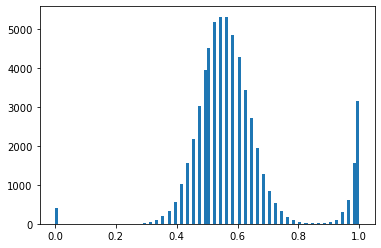

In [6]:
import matplotlib.pyplot as plt

plt.hist(outputs['correct'], bins = 100)
plt.show()

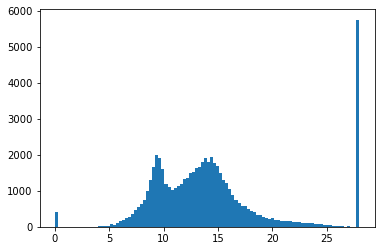

In [7]:
plt.hist(outputs['predictions'], bins = 100)
plt.show()

In [3]:
import numpy as np
from sklearn.neighbors import KDTree


In [6]:
train_X = experiment.train_set.data / 255
train_X = train_X.view(len(train_X), -1).numpy()
train_tree = KDTree(train_X, leaf_size=2)              


In [4]:
test_X = experiment.val_set.data / 255
test_X = test_X.view(len(test_X), -1).numpy()
test_tree = KDTree(test_X, leaf_size=2)              


In [17]:
dist, ind = train_tree.query(test_X, k = 3)

# ind = tree.query_radius(X[:1], r=0.3)  
# print(ind)  # indices of neighbors within distance 0.3


In [18]:
dist, ind

(array([[2.65327087, 3.11367363, 3.3830457 ],
        [4.56051623, 4.75233123, 5.0428567 ],
        [1.26142301, 1.30377855, 1.33744462],
        ...,
        [3.86491829, 4.0891902 , 4.28055521],
        [5.15203235, 5.23888692, 5.40504272],
        [3.97997873, 4.80850204, 5.10451476]]),
 array([[53843, 38620, 16186],
        [28882, 49160, 24612],
        [58741, 46512, 15224],
        ...,
        [ 3261, 58994, 35362],
        [36407,  1311,  6011],
        [22424,  5179,  5329]]))

In [69]:
experiment.train_set.targets[ind][:, 0]

tensor([7, 2, 1,  ..., 4, 5, 6])

In [71]:
sum(experiment.val_set.targets == experiment.train_set.targets[ind][:, 0])

tensor(9691)

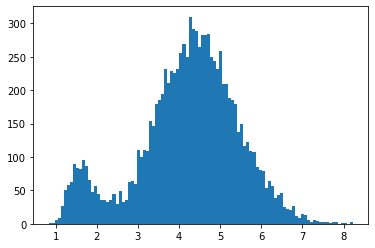

In [25]:
import matplotlib.pyplot as plt
plt.hist(dist.min(1), bins = 100)
plt.show()

In [11]:
from tqdm.notebook import trange
all_in = set()
for i in trange(len(train_X)):
    ind = test_tree.query_radius(train_X[i:i+1], r=outputs['predictions'][i])
    all_in.update(set(ind[0].tolist()))
    if len(all_in) == len(test_X):
        break

# ind = tree.query_radius(X[:1], r=0.3)  
# print(ind)  # indices of neighbors within distance 0.3


  0%|          | 0/60000 [00:00<?, ?it/s]

In [12]:
len(all_in)

10000

41466 55161


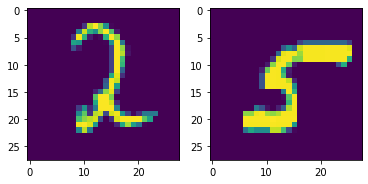

In [30]:
import random

ka = random.randint(0, 60000)
kb = random.randint(0, 60000)
print(ka, kb)
a = experiment.train_set.data[ka].repeat(1, 1, 1, 1) / 255
b = experiment.train_set.data[kb].repeat(1, 1, 1, 1) / 255
la = experiment.train_set.targets[ka]
lb = experiment.train_set.targets[kb]

figure, ax = plt.subplots(1, 2)
ax[0].imshow(a.squeeze())
ax[1].imshow(b.squeeze())
plt.show()
a = a.cuda()
b = b.cuda()




In [31]:
from utils.sampling import sample_uniform_l2, forward_samples


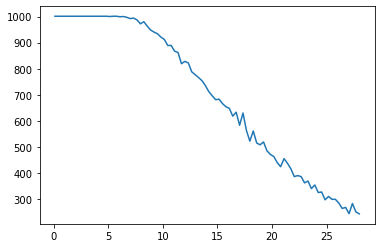

In [32]:
rate_a = []
epsilons = np.linspace(0.1, 28, 90)
for eps in epsilons:
    scores_a, inputs_a = forward_samples(m, sample_uniform_l2, a, eps, 1000, batch_size = 10000)
    rate_a.append((scores_a.argmax(-1) == la).sum().item())

plt.plot(epsilons, rate_a)

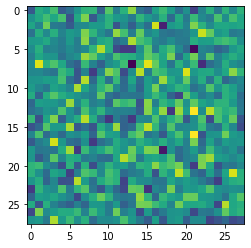

In [61]:
plt.imshow(inputs_a[5].squeeze().cpu())

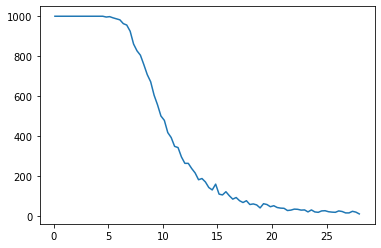

In [33]:
rate_b = []
epsilons = np.linspace(0.1, 28, 90)
for eps in epsilons:
    scores_b, inputs_b = forward_samples(m, sample_uniform_l2, b, eps, 1000, batch_size = 10000)
    rate_b.append((scores_b.argmax(-1) == lb).sum().item())

plt.plot(epsilons, rate_b)

In [34]:
mid = (a + b) / 2
eps = torch.where(a > b, a, b) / 2
scores_mid, inputs_mid = forward_samples(m, sample_uniform_l2, mid, eps, 1000, batch_size = 10000)


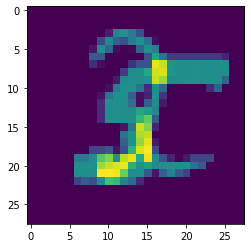

In [35]:
plt.imshow(mid.cpu().squeeze())

In [36]:
((a - b) ** 2).sum() ** 0.5

tensor(9.8612, device='cuda:0')

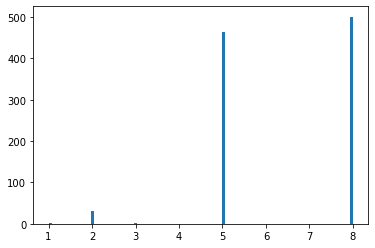

In [37]:
plt.hist(scores_mid.argmax(-1).squeeze().tolist(), bins = 100)
plt.show()

(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 3.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00,
        1.0000e+00, 7.0000e+00, 3.0000e+00, 1.0000e+00, 3.0000e+00,
        2.0000e+00, 3.0000e+00, 4.0000e+00, 5.0000e+00, 8.0000e+00,
        3.0000e+00, 1.0000e+01, 1.2000e+01, 1.2000e+01, 1.1000e+01,
        1.3000e+01, 1.4000e+01, 1.6000e+01, 1.5000e+01, 1.8000e+01,
        2.6000e+01, 2.2000e+01, 3.5000e+01, 4.4000e+01, 4.3000e+01,
        4.5000e+01, 4.3000e+01, 5.6000e+01, 7.5000e+01, 9.3000e+01,
        8.2000e+01, 8.2000e+01, 1.1900e+02, 1.4200e+02, 1.6700e+02,
        1.7100e+02, 2.0800e+02, 2.1400e+02, 2.3700e+02, 2.7600e+02,
        3.1200e+02, 3.3400e+02, 4.3100e+02, 4.13

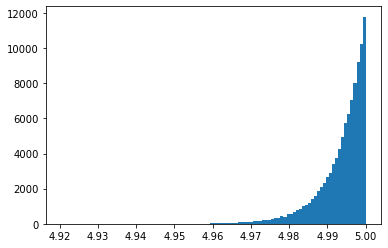

In [57]:
plt.hist((((sample_uniform_l2(mid, 5, 100000) - mid) ** 2 ).sum(dim = (-1, -2), keepdim = True) ** 0.5)[1:].flatten().tolist(), bins = 100)
# plt.show()